In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
#import pandas as pd
import healpy as hp
import time
import warnings
from pixell import reproject
#from classy import Class
%matplotlib inline
#import s1 
import ST
from scipy.integrate import trapz

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import spherical

In [4]:
import quaternionic


In [5]:

ell_max = 3*16-1
# Use the largest ℓ value you expect to need
wigner = spherical.Wigner(ell_max)

In [6]:
R = quaternionic.array.from_spherical_coordinates(np.linspace(0,np.pi, 100), np.linspace(0, 2*np.pi, 100))

#np.arange(0,np.pi, 100), np.arange (0,2*np.pi, 100)


In [43]:
D[wigner.Dindex(1, 0, 1)]


array([ 1.        +0.j        ,  0.91997952-0.36830424j,
        0.12423497-0.04973618j, ...,  0.22823901-0.32051684j,
       -0.3505199 +0.49223632j,  0.37861519-0.53169064j])

In [44]:
D[wigner.Dindex(1, 1, 0)]

array([ 1.        +0.j        ,  0.85984537-0.47840512j,
        0.15518555-0.08634292j, ...,  0.1496235 -0.48119237j,
       -0.17193228+0.55293786j,  0.13895608-0.44688571j])

In [48]:
(1-1.j).conjugate


<function complex.conjugate>

In [140]:

def beam2bl(beam, theta, lmax):
    """Computes a transfer (or window) function b(l) in spherical
    harmonic space from its circular beam profile b(theta) in real
    space.
    Parameters
    ----------
    beam : array
        Circular beam profile b(theta).
    theta : array
        Radius at which the beam profile is given. Has to be given
        in radians with same size as beam.
    lmax : integer
        Maximum multipole moment at which to compute b(l).
    Returns
    -------
    bl : array
        Beam window function b(l).
    """

    nx = len(theta)
    nb = len(beam)
    if nb != nx:
        raise ValueError("Beam and theta must have same size!")

    x = np.cos(theta)
    st = np.sin(theta)
    window = np.zeros(lmax + 1, dtype = np.complex128)

    p0 = np.ones(nx)
    p1 = np.copy(x)

    window[0] = trapz(beam * p0 * st, theta)
    window[1] = trapz(beam * p1 * st, theta)

    for l in np.arange(2, lmax + 1):
        p2 = x * p1 * (2 * l - 1) / l - p0 * (l - 1) / l
        window[l] = trapz(beam * p2 * st, theta)
        p0 = p1
        p1 = p2

    window *= 2 * np.pi
    return window



    
    

def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g


def morlet (f, sigma, theta, lmax):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=beam2bl(wv,theta,lmax)[0]/beam2bl(wvm,theta,lmax)[0]
    mor=wv-B*wvm
    #norm = np.mean(np.abs(mor)**2*np.sin(theta))
    #mor = mor/norm
    print ("hi")
    return mor


 

def morlet_arr (resol, jmax, lmax, theta_bin) :
    morl=[]
    fl2beam=[]
    
    theta=np.linspace(0,np.pi,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = morlet (freq1, sigma1, theta, lmax)
        mor_l = beam2bl(morf, theta, lmax)
        morl.append(mor_l)
    
    return morl



def gabor_prj(freq,sigma,theta):
    
    arg=-(4*np.tan(theta/2)**2)/(2*sigma*sigma) + 2.j * freq*np.tan(theta/2)
    
    g=np.exp(arg)
    g/= (1+np.cos(theta))
    g/=2*np.pi*sigma*sigma
    return g


def morlet_prj (f, sigma, theta, lmax):
    wv=gabor_prj(f,sigma,theta)
    wvm=gabor_prj(0,sigma, theta)
    B=beam2bl(wv,theta,lmax)[0]/beam2bl(wvm,theta,lmax)[0]
    mor=wv-B*wvm
    #norm = np.mean(np.abs(mor)**2*np.sin(theta))
    #mor = mor/norm
    print ("hihi")
    return mor


 

def morlet_arr_prj (resol, jmax, lmax, theta_bin) :
    morl=[]
    fl2beam=[]
    
    theta=np.linspace(0,np.pi-0.0001,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = morlet_prj (freq1, sigma1, theta, lmax)
        mor_l = beam2bl(morf, theta, lmax)
        morl.append(mor_l)
    
    return morl


def compS1 (hmap, mor_l, jmax, nside , gaus_l = None , lmax = None , resol = None):

    #if lmax == None :
        #lmax = 3 * nside - 1 
    
    if resol==None :
        resol = hp.nside2resol(nside, arcmin =False )
        
    
    S1=np.zeros((jmax))
    i1=[]
    
    mapalm=hp.map2alm(hmap, lmax, use_pixel_weights=True)
    
    #mor_l = morlet_arr(resol, jmax, lmax, jbin)
    #gaus_l = gaus_arr(resol, jmax, jbin)
    
    for j in range(jmax):
        print(j)
        
        #morlet filter 
        
        morl = np.real(mor_l[j])
        
        #convolving the map with filter 1

        nalm=hp.almxfl(mapalm,morl)
        
        I1=hp.alm2map(nalm, nside, lmax)
        

        #modulus
        I1=np.abs(I1)

        i1.append(I1)
        #Gaussian filter for S1
        
        
        
        if gaus_l == None:
            
            S1map = I1
            
        else:
        
            gausl = gaus_l[j]
            #Convolving with gaussian filter to get S1
            I1alm=hp.map2alm(I1, lmax, use_pixel_weights=True)
            
            nI1alm=hp.almxfl(I1alm, gausl)
        
            S1map=hp.alm2map(nI1alm, nside, lmax)
        
    
        #Averaging the entire map
        S1[j]=np.mean(S1map)
        
    return S1 , i1


In [4]:
def morlet_arr (resol, jmax, lmax, theta_arr) :
    morl=[]
    fl2beam=[]
    
    #theta=np.linspace(0,np.pi,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = ST.morlet (freq1, sigma1, theta_arr, lmax)
        #print ("ok")
        #norm = np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin)
        #morf /= norm
        #print ("okk")
        mor_l = ST.beam2bl(morf, theta_arr, lmax)
        #norm = np.sqrt(np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin))
        #print ("hello")
        morl.append(mor_l)
    
    return morl

In [5]:
def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
    return(0)
  ###############################

# defining parameters and a Gaussian map

In [7]:
nside = 128

In [8]:
lmax = 3*nside -1 
res_rad = hp.nside2resol(nside, arcmin = False)
res_arcmin = hp.nside2resol(nside, arcmin = True)

In [9]:
ell = np.arange(0,lmax+1)
ellsc = 21600/ell
norm= ell * (ell+1) / (2*np.pi)

/var/folders/vj/5ltjqv9d4px7nr3d4mbmk9_m0000gn/T/ipykernel_4930/2172233455.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc = 21600/ell


In [10]:
dl_test = ell**2 #( ell**2) / (1e8 + ell**4) * 2e8
cl_test = np.zeros (lmax+1)
cl_test[1:] = dl_test[1:]/ norm[1:]
cl_test[0] = 0

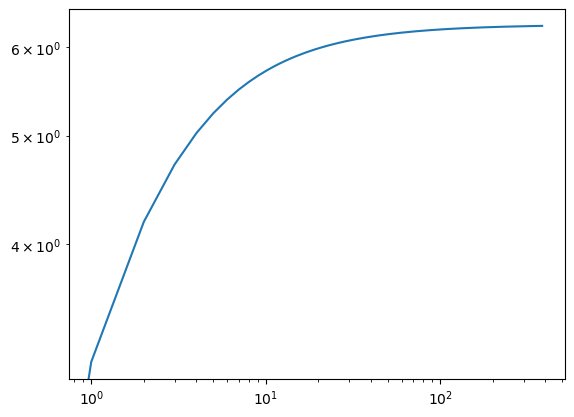

In [11]:
plt.loglog (ell , cl_test)

Text(0, 0.5, 'Dl')

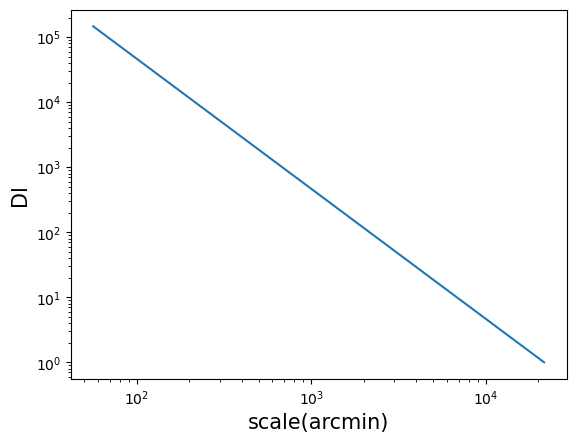

In [23]:
plt.loglog (ellsc , dl_test)
plt.xlabel("scale(arcmin)")
plt.ylabel("Dl")

In [24]:
map_test = hp.synfast (cl_test , nside)
#map_test += np.abs (min(map_test))
#map_test /= np.max(map_test)
alm_test = hp.map2alm (map_test)
almsize = alm_test.shape[0]
mapsize = map_test.shape[0]


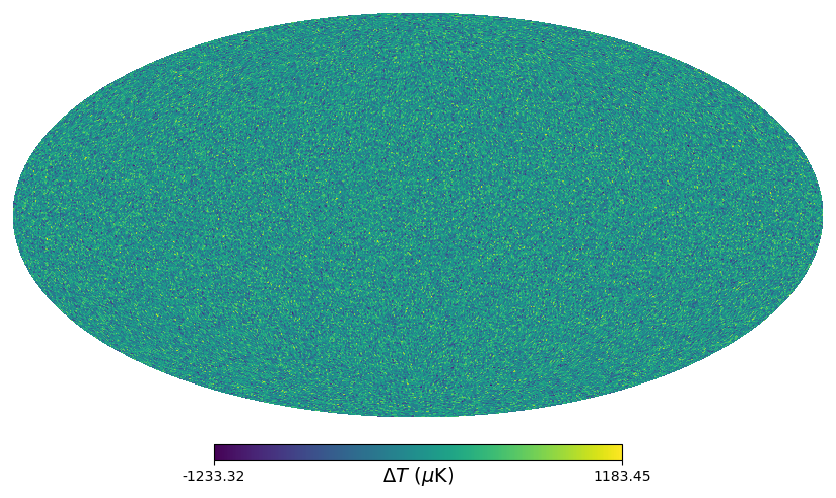

In [25]:
hp.mollview(map_test, title="" , unit=r"$\Delta T \ (\mu $K)")

In [26]:
jmax = 8

# defining the morlet map 

In [57]:
mor_map = np.zeros(mapsize)
ids = np.arange (mapsize)
theta_arr, phi_arr = hp.pix2ang (nside, ids)


In [76]:

mor_arr = []
for j in range (jmax):
    sigma = (0.8*res_rad*2**j)
    freq =(3.0*np.pi) /(4.0*res_rad*2**j)
    mor = morlet(freq, sigma, theta_arr, lmax)
    mor_arr.append(mor)



hi
hi
hi
hi
hi
hi
hi


/var/folders/vj/5ltjqv9d4px7nr3d4mbmk9_m0000gn/T/ipykernel_66547/736917042.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  mor_map[ids] = mor_arr[j]#+np.abs (np.min(mor_arr[j]))


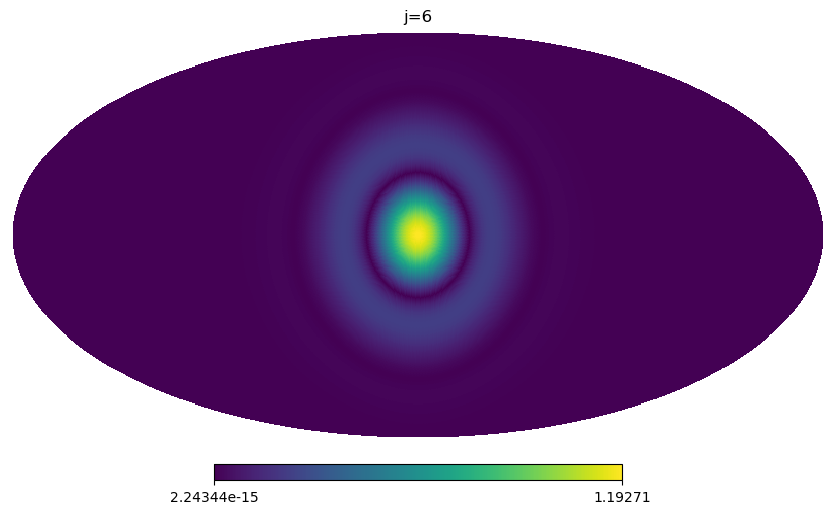

In [77]:
j = 6
mor_map[ids] = mor_arr[j]#+np.abs (np.min(mor_arr[j]))
mapp = hp.mollview(np.abs(mor_map), rot=[0,90], title="j=%d"%j )
plt.savefig("Morlet_map_2.pdf")

# Computing ST coefficients


In [12]:
morlet_l_arr = []
for j in range (jmax):
    mor_l = hp.beam2bl(mor_arr[j], theta_arr, lmax)
    morlet_l_arr.append(mor_l)

NameError: name 'mor_arr' is not defined

In [27]:
theta_bin = 100000
morlet_l_arr = ST.morlet_arr(res_rad , jmax , lmax , theta_bin)

In [33]:
theta_bin = 100000
morlet_l_arr_prj = morlet_arr_prj(res_rad , jmax , lmax , theta_bin)

hihi
hihi
hihi
hihi
hihi
hihi
hihi
hihi
hihi
hihi


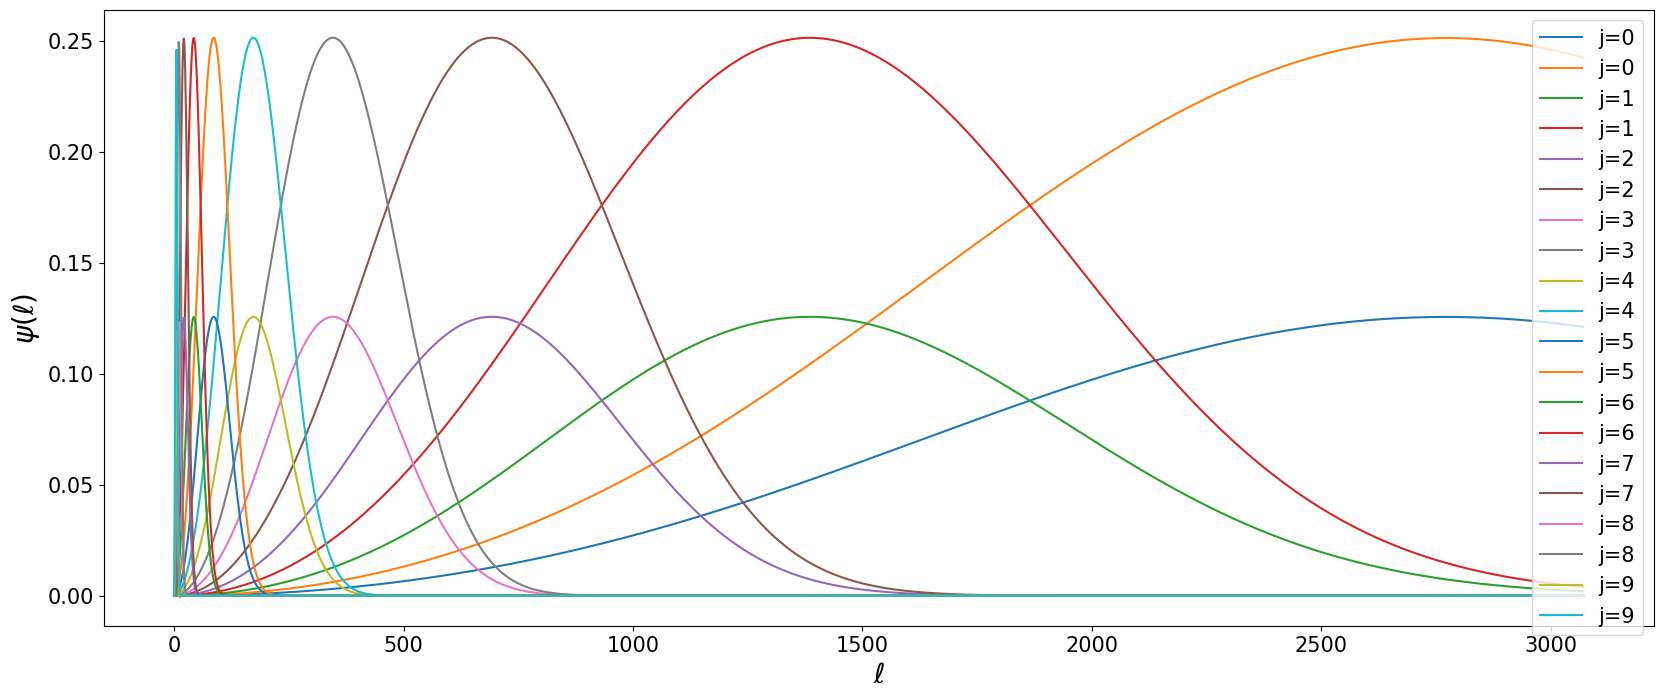

In [34]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):
    plt.plot(ell,np.real(morlet_l_arr_prj[j]),label='j='+str(j))
    plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 15})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$\psi(\ell)$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig("profile.pdf")

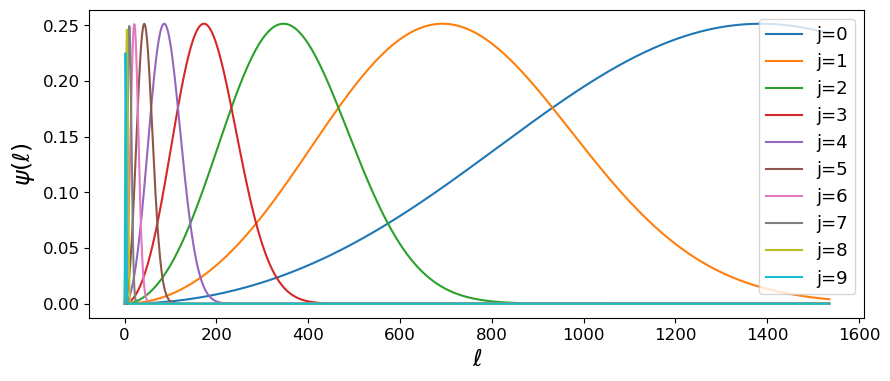

In [120]:
fig=plt.figure(figsize=[10,4])
for j in range(jmax):
    #plt.plot(ell,np.real(morlet_l_arr_prj[j]),label='j='+str(j))
    plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 13})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=17)
plt.ylabel("$\psi(\ell)$", size=17)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig("profile.pdf")

/var/folders/vj/5ltjqv9d4px7nr3d4mbmk9_m0000gn/T/ipykernel_61797/468580693.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(ell,np.abs(morlet_l_arr[j])**2/ell*2,label='j='+str(j))


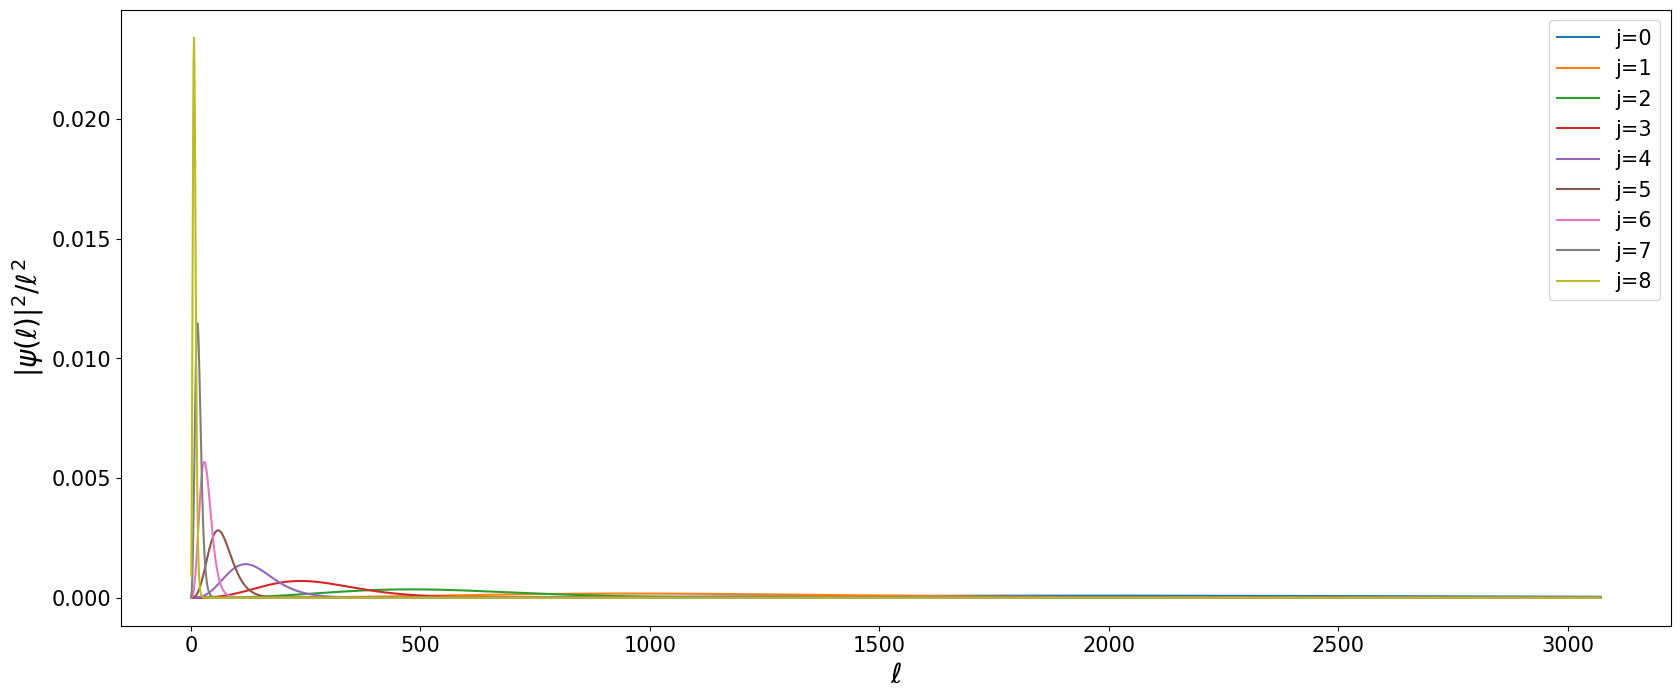

In [17]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):

    plt.plot(ell,np.abs(morlet_l_arr[j])**2/ell*2,label='j='+str(j))
    plt.legend(prop={'size': 15})

    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$|\psi(\ell)|^2/\ell^2$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig ("admissible.pdf")

In [29]:
Jf=np.arange(jmax)
scale = 2**Jf*((2*res_arcmin)/0.75)

In [164]:
s0 = np.mean(map_test)

In [31]:
s1, i1 = ST.compS1(map_test, morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7


In [28]:
s1_prj, i1_prj = ST.compS1(map_test, morlet_l_arr_prj, jmax, nside)

0
1
2
3
4
5
6
7
8
9


In [62]:
s2, i2 = ST.compS2(i1, morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7
8
9


In [ ]:
s2_prj, i2_prj = ST.compS2(i1_old, morlet_l_arr_prj, jmax, nside)

0
1
2
3
4
5


Text(0.5, 0, 'scale(arcmin)')

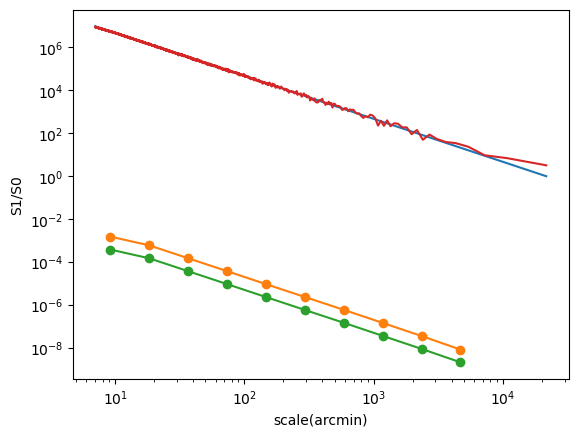

In [36]:
plt.loglog(ellsc , dl_test)
plt.loglog(scale, (s1_old/s0)**2, 'o-', lw=1.5)
plt.loglog(scale, (s1/s0)**2, 'o-', lw=1.5)
plt.loglog(ellsc , hp.anafast(map_test)*ell*(ell+1)/(2*np.pi))
plt.ylabel("S1/S0")
plt.xlabel("scale(arcmin)")

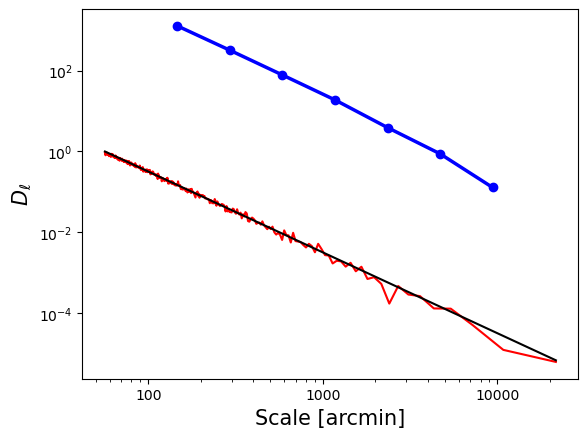

In [39]:

#plt.loglog(scale, (s1_old/s0)**2, 'o-', lw=1.5)
plt.loglog(ellsc , hp.anafast(map_test)*ell*(ell+1)/(2*np.pi)/np.max(dl_test) , color = "red")
plt.loglog(scale[1:], (s1[1:])**2, 'o-', lw=2.5 , color = "blue")
plt.loglog(ellsc , dl_test/np.max(dl_test) , color = "black")
#plt.ylabel("S1/S0")
plt.xlabel("Scale [arcmin]")
plt.ylabel (r"$D_\ell$")
#plt.legend ([r"$D_\ell$", r"$S_1^2$" ])
plt.xticks ([100, 1000, 10000],[100, 1000, 10000])
plt.savefig("Gaus_test.pdf", bbox_inches = 'tight', pad_inches=0.1)

In [20]:
I0sqrt = np.mean(map_test**2)

In [23]:
(I0sqrt-s0**2)/I0sqrt

0.032563876423331035

In [24]:
np.sum(s1**2)/(I0sqrt-s0**2)

0.06806046513970423

[ 2.79021393e-01+0.00000000e+00j  4.83116542e-01+0.00000000e+00j
  6.23907837e-01+0.00000000e+00j ...  2.49796209e-20-3.34109407e-20j
  5.11956423e-21-5.32207591e-20j -4.03108762e-20+1.11276666e-20j]


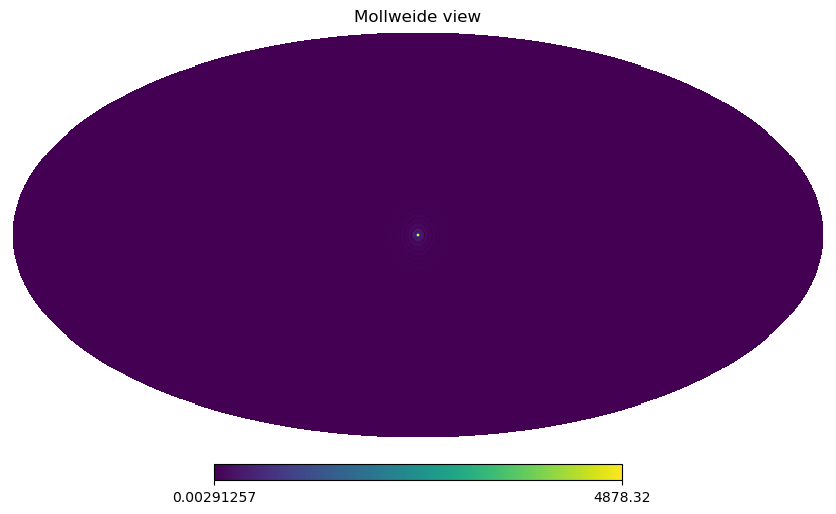

In [97]:
alm_delta = np.zeros (almsize, dtype = np.complex128)
alm_delta[:lmax+1] =  np.sqrt ((2*np.arange (0,lmax+1)+1)/(4*np.pi))
#alm_delta = hp.almxfl(alm_delta, morlet_l_arr[7])
map_delta = hp.alm2map(alm_delta,nside)
#map_delta += np.abs (np.min(map_delta))
#map_delta *=mapsize/(np.sum(map_delta))
hp.mollview(np.abs(map_delta), rot = [0,90])
print (hp.map2alm(map_delta))

In [96]:
np.where(map_delta<0)

(array([     4,      5,      6, ..., 196593, 196594, 196595]),)

In [98]:
s1_delta , i1_delta = ST.compS1(map_delta,morlet_l_arr,jmax, nside)

0
1
2
3
4
5
6


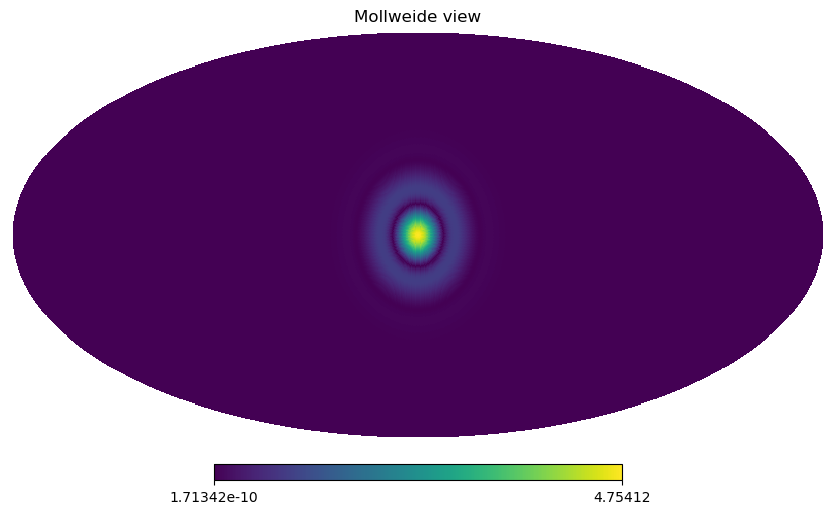

In [102]:
hp.mollview(i1_delta[5], rot=[0,90])

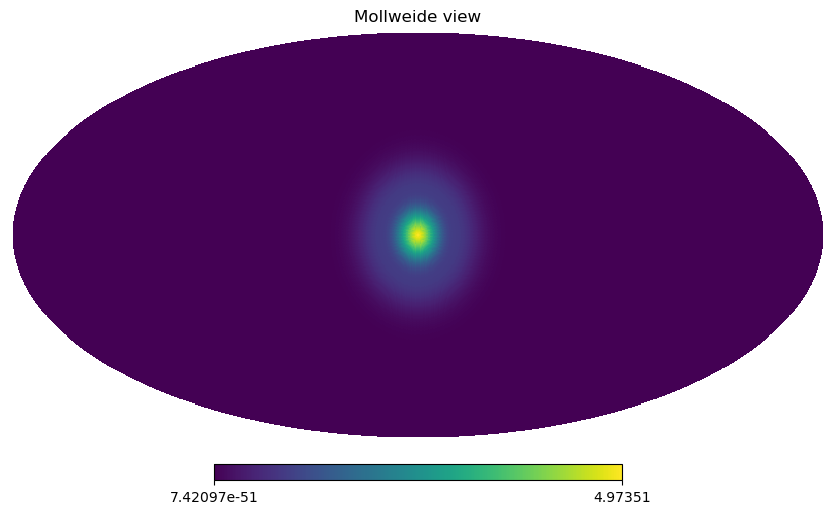

In [100]:
hp.mollview(np.abs(mor_arr[5]), rot=[0,90])

In [103]:
hp.map2alm(np.abs(mor_arr[5]))

array([ 2.30928184e-01+0.00000000e+00j,  3.80617169e-01+0.00000000e+00j,
        4.44949453e-01+0.00000000e+00j, ...,
        2.09910511e-23+3.61143977e-23j,  3.36282567e-24+2.27450749e-24j,
       -1.58535301e-23-5.15413982e-24j])

In [105]:
hp.map2alm(i1_delta[5])

array([ 1.48791872e-01+0.00000000e+00j,  2.47013848e-01+0.00000000e+00j,
        2.94418817e-01+0.00000000e+00j, ...,
       -1.56334053e-23+7.33000021e-24j,  1.12134508e-23-3.80157662e-23j,
       -2.10543862e-23-3.55184308e-23j])

In [119]:
hp.map2alm((hp.alm2map(hp.almxfl(alm_delta,morlet_l_arr[5]),nside)))

array([-1.57558688e-06+0.00000000e+00j,  3.40844982e-03+0.00000000e+00j,
        1.34182181e-02+0.00000000e+00j, ...,
       -1.62199199e-23+4.22413079e-23j, -1.13048588e-23+1.14108919e-23j,
       -1.39211716e-23-3.79519219e-23j])

In [111]:
alm_delta[:lmax+1]*morlet_l_arr[5]

array([-6.96905358e-19-8.55482665e-18j,  3.41126829e-03+9.92027115e-03j,
        1.34217422e-02+3.59736787e-02j,  3.22349102e-02+7.70354934e-02j,
        6.12857263e-02+1.27131548e-01j,  1.00611949e-01+1.77254081e-01j,
        1.48270877e-01+2.17648850e-01j,  2.00186984e-01+2.40128266e-01j,
        2.50625704e-01+2.39882458e-01j,  2.93237296e-01+2.16386887e-01j,
        3.22387013e-01+1.73253904e-01j,  3.34372028e-01+1.17159558e-01j,
        3.28163371e-01+5.62067710e-02j,  3.05479099e-01-1.80613644e-03j,
        2.70218845e-01-5.07802787e-02j,  2.27480451e-01-8.70992661e-02j,
        1.82471455e-01-1.09735487e-01j,  1.39604492e-01-1.19804212e-01j,
        1.01955744e-01-1.19803863e-01j,  7.11253591e-02-1.12799805e-01j,
        4.74220857e-02-1.01750597e-01j,  3.02331140e-02-8.90789981e-02j,
        1.84374558e-02-7.64957802e-02j,  1.07591499e-02-6.50203474e-02j,
        6.00944929e-03-5.51164749e-02j,  3.21346672e-03-4.68674512e-02j,
        1.64544301e-03-4.01380628e-02j,  8.06931199

In [108]:
hp.map2alm(map_delta)

array([ 2.79021393e-01+0.00000000e+00j,  4.83116542e-01+0.00000000e+00j,
        6.23907837e-01+0.00000000e+00j, ...,
        2.49796209e-20-3.34109407e-20j,  5.11956423e-21-5.32207591e-20j,
       -4.03108762e-20+1.11276666e-20j])

In [109]:
morlet_l_arr[5]

array([-2.47046517e-18-3.03260709e-17j,  6.98168390e-03+2.03033568e-02j,
        2.12779029e-02+5.70301851e-02j,  4.31899177e-02+1.03215942e-01j,
        7.24174144e-02+1.50223201e-01j,  1.07537058e-01+1.89454460e-01j,
        1.45777035e-01+2.13988105e-01j,  1.83229391e-01+2.19787297e-01j,
        2.15479560e-01+2.06242879e-01j,  2.38477460e-01+1.75978281e-01j,
        2.49386433e-01+1.34022685e-01j,  2.47155883e-01+8.66001685e-02j,
        2.32661772e-01+3.98495631e-02j,  2.08403280e-01-1.23217844e-03j,
        1.77877725e-01-3.34272780e-02j,  1.44833213e-01-5.54547281e-02j,
        1.12601169e-01-6.77165866e-02j,  8.36508391e-02-7.17865358e-02j,
        5.94176905e-02-6.98192041e-02j,  4.03735651e-02-6.40296276e-02j,
        2.62538896e-02-5.63313256e-02j,  1.63438206e-02-4.81555146e-02j,
        9.74315624e-03-4.04237085e-02j,  5.56331896e-03-3.36205868e-02j,
        3.04327758e-03-2.79118309e-02j,  1.59512107e-03-2.32643638e-02j,
        8.01216422e-04-1.95444478e-02j,  3.85709286

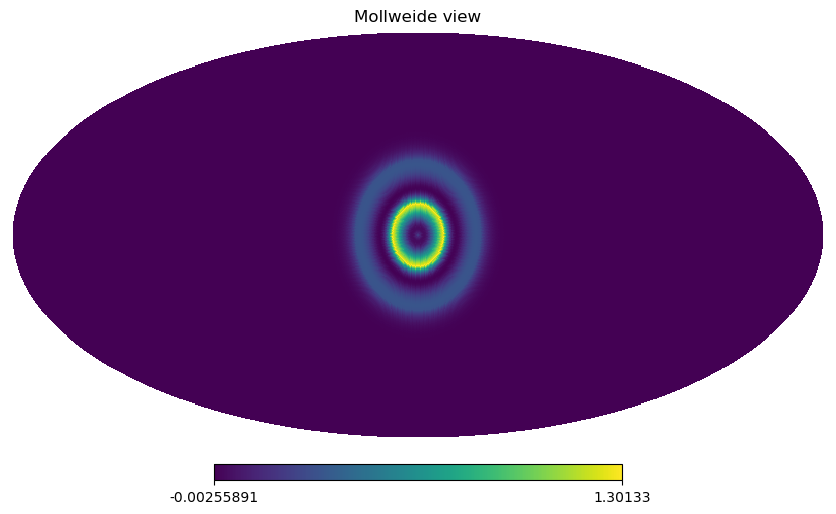

In [101]:
hp.mollview((np.abs(mor_arr[5])-i1_delta[5]), rot=[0,90])

In [59]:
s1_normalized = s1/s1_delta

In [60]:
s1_normalized

array([1.14549360e+07, 6.98192398e+07, 3.79266855e+07, 1.33688628e+07,
       4.68271181e+06, 1.64023057e+06, 5.69007518e+05, 1.98685529e+05,
       7.01407409e+04, 2.40514912e+04])

In [49]:
s1

array([459.17065695, 287.27650303, 144.46788913,  72.0851742 ,
        35.90152752,  17.83529147,   8.75097231,   4.31168737,
         2.13103041,   0.99374432])

In [50]:
(I0sqrt-(s0**2+np.sum(s1_normalized**2)))/I0sqrt

0.032563876423064894

In [35]:
s2_delta , i2_delta = ST.compS2(i1_delta, morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7


In [36]:
s2_normalized = s2/s2_delta 

In [37]:
s2_sum = 0 
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax):
        s2_sum += s2[j1,j2]**2

In [38]:
(I0sqrt-(s0**2+np.sum(s1**2)+s2_sum))/I0sqrt

0.042192990754885015

In [ ]:
map_sqrt = map_test**10

In [ ]:
s1_sqrt , i1_sqrt = ST.compS1(map_sqrt, morlet_l_arr, jmax, nside)

In [ ]:
s2_sqrt, i2_sqrt = ST.compS2(i1_sqrt, morlet_l_arr, jmax, nside)

In [ ]:
I0sqrt_sqrt = np.mean(map_sqrt**2)

In [ ]:
s0_sqrt = np.mean(map_sqrt)

In [ ]:
s1_sqrt_norm = s1_sqrt/s1_delta

In [ ]:
s2_sqrt_norm = s2_sqrt/s2_delta

In [ ]:
s2_sum_sqrt = 0 
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax):
        s2_sum_sqrt += s2_sqrt[j1,j2]**2

In [ ]:
(I0sqrt_sqrt-(s0_sqrt**2))/I0sqrt_sqrt

In [ ]:
np.sum(s1_sqrt**2)/(I0sqrt_sqrt-s0_sqrt**2)

In [ ]:
(I0sqrt_sqrt-(s0_sqrt**2+np.sum(s1_sqrt**2)+s2_sum_sqrt))/I0sqrt_sqrt

In [ ]:
s2_sum_sqrt/(I0sqrt_sqrt-s0_sqrt**2)

# Adding non-Gaussianity 

In [ ]:
cov_mat = np.zeros ((almsize , almsize))
for l in range (lmax+1):
    cov_mat [ , l ] = np.sqrt (cl_test[l])

In [ ]:
import random
for l in range (almsize):
    for j in range (l+1,almsize):
        cov_mat[l,j] = random.uniform(0,np.max(cov_mat))

In [ ]:
for l in range (lmax+1):
    for j in range (0,l):
        cov_mat[l,j] = cov_mat[j,l]
        

In [ ]:
cov_matt = np.zeros ((jmax , jmax))
#for l in range (jmax):
#    cov_mat [l , l ] = np.sqrt (cl_test[l])

In [ ]:
import random
for l in range (jmax):
    for j in range (l+1,jmax):
        cov_matt[l,j] = random.uniform(0,np.max(np.sqrt(cl_test)))

In [ ]:
for l in range (jmax):
    for j in range (l+1,jmax):
        cov_matt[j,l] = cov_matt[l,j]

In [ ]:
num = int((lmax+1)/jmax)
cov_mat = np.zeros ((lmax+1 , lmax+1))

In [ ]:



for i in range (jmax):
    for j in range (jmax):
        tmp =  np.ones((num,num)) * cov_matt[i,j]
        #print (tmp)
        cov_mat [i*num:(i+1)*num , j*num:(j+1)*num] = tmp
        #print (i*num,j*num )


In [ ]:
for i in range (lmax+1):
    
    
    
    cov_mat[i,i] = 1#np.sqrt(cl_test)[i]
    

In [588]:
cov_mat /= np.max(cov_mat)
mixed_l = np.matmul(cov_mat , np.ones (lmax+1)*np.sqrt(cl_test))
#mixed_l /= np.max (mixed_l)

In [589]:
mixed_alm = hp.almxfl(alm_test , mixed_l)

In [590]:
mixed_map = hp.alm2map(mixed_alm, nside)
mixed_map += np.abs (np.min(mixed_map))

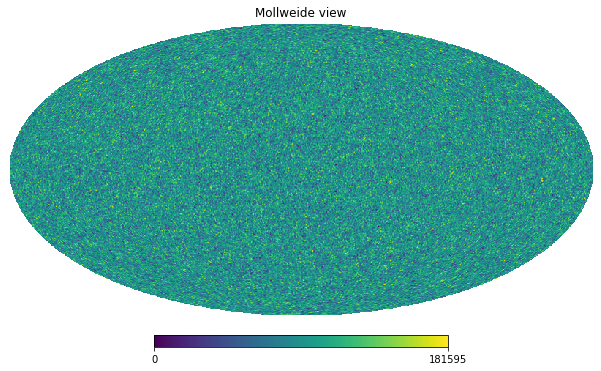

In [591]:
hp.mollview(mixed_map)

In [592]:
mixed_cl = hp.alm2cl (mixed_alm)

In [593]:
mixed_dl  = mixed_cl *ell*(ell+1)/(2*np.pi)

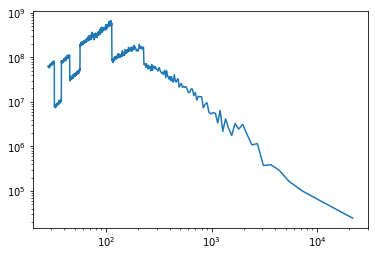

In [594]:
plt.loglog (ellsc , mixed_dl)

Text(0.5, 0, 'scale(arcmin)')

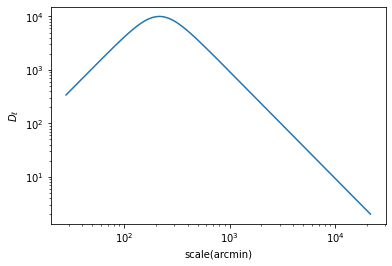

In [916]:
plt.loglog (ellsc , dl_test)
plt.ylabel("$D_\ell$")
plt.xlabel("scale(arcmin)")

In [596]:
s0_mixed = np.mean(mixed_map)

In [597]:
I0sqrt_mixed = np.mean(mixed_map**2)

In [598]:
s1_mixed , i1_mixed = ST.compS1(mixed_map , morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7


In [599]:
s2_mixed , i2_mixed = ST.compS2(i1_mixed , morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7


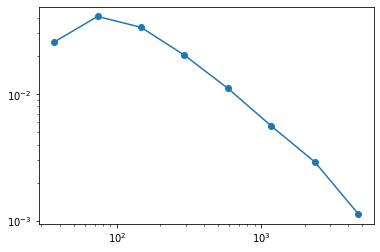

In [600]:
plt.loglog(scale, s1_mixed/s0_mixed, 'o-', lw=1.5)

In [601]:
s2_sum_mixed = 0 
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax):
        s2_sum_mixed += s2_mixed[j1,j2]**2

In [602]:
(I0sqrt_mixed-(s0_mixed**2))/I0sqrt_mixed

0.047166607032148804

In [603]:
np.sum(s1_mixed**2)/(I0sqrt_mixed-s0_mixed**2)

0.08113798546032208

In [604]:
(I0sqrt_mixed-(s0_mixed**2+np.sum(s1_mixed**2)+s2_sum_mixed))/I0sqrt_mixed

0.04330493115518788

In [605]:
s2_sum_mixed/(I0sqrt_mixed-s0_mixed**2)

0.0007351048454716879

In [606]:
mixed_alm

array([ 1.83418826e+05 +0.j        ,  4.75904714e+02 +0.j        ,
        1.30595323e+02 +0.j        , ...,  6.56371131e+00-19.88549324j,
        1.91258561e+00+10.81485238j, -2.88724900e+01 +2.77988209j])

In [607]:
alm_test

array([ 2.23771034e+03+0.j        ,  5.75515113e+00+0.j        ,
        1.57716049e+00+0.j        , ...,  1.50407003e-02-0.04556747j,
        4.38267753e-03+0.02478216j, -6.61611237e-02+0.00637008j])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


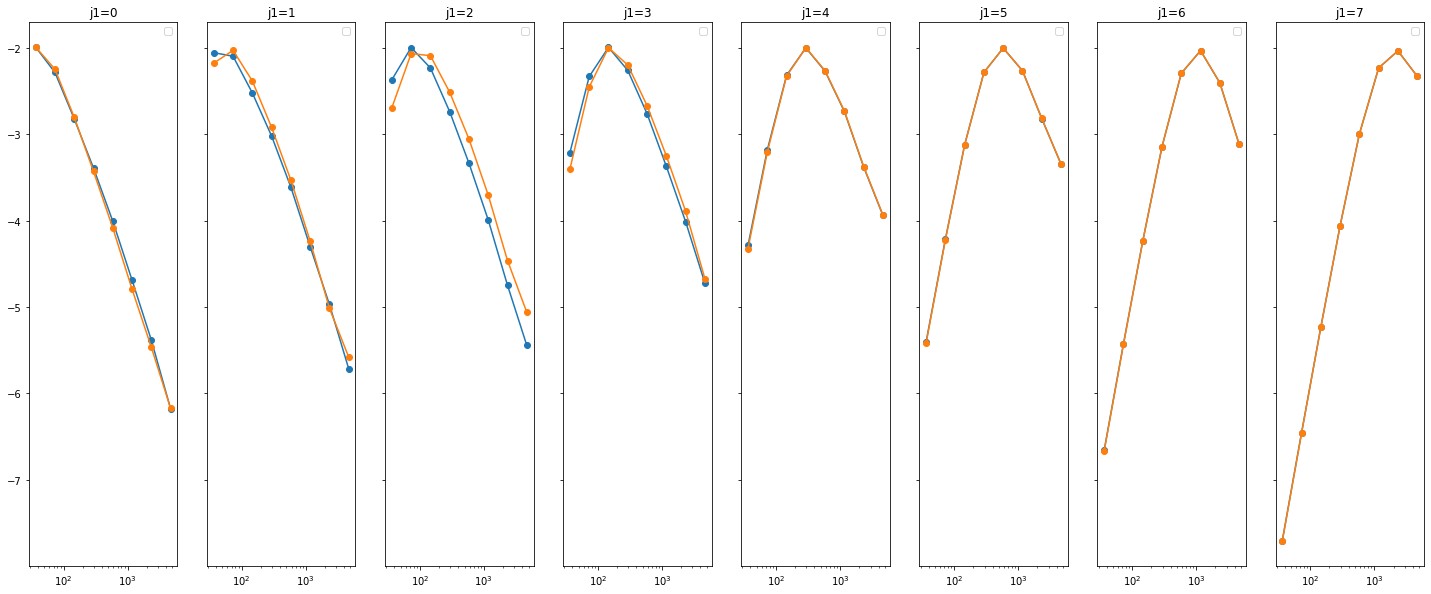

In [608]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale,np.log(s2_mixed[j,:]/s1_mixed[j]),'o-')
    ax[j].plot (scale,np.log(s2[j,:]/s1[j]),'o-')
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()
#fig.legend (["nside=256" ,"nside=2048"])

In [68]:
def SZ_source_component(N,nside,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,do_plots):
    "makes a realization of a naive SZ map"
    N=int(N)
    SZMap = np.zeros(N)
    SZcat = np.zeros([2,Number_of_SZ_Clusters]) ## catalogue of SZ sources, ipix, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        ipix = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        SZcat[0,i] = ipix
        SZcat[1,i] = pix_amplitude
        SZMap[ipix] += pix_amplitude
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(SZMap,bins = 50,range=[SZMap.min(),-10])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('source amplitude [$\mu$K]')
        plt.ylabel('number of pixels')
        plt.show()
    # make a beta function
    theta , phi = hp.pix2ang(nside, np.arange (0,hp.nside2npix(nside)))
    beta = beta_function(nside,SZ_beta,SZ_Theta_core)
    
    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = hp.beam2bl(beta,theta , lmax)
    FT_SZMap = hp.map2alm(SZMap)
    SZMap = np.real(hp.alm2map(hp.almxfl(FT_SZMap,FT_beta), nside))
    
    # return the SZ map
    return(SZMap,SZcat)    
  ############################### 

In [69]:
### paramaters to set up the SZ point sources
Number_of_SZ_Clusters  = 10000
Mean_Amplitude_of_SZ_Clusters = 50000
SZ_beta = 0.86
SZ_Theta_core = 0.001

In [70]:
def beta_function(nside,SZ_beta,SZ_Theta_core):
  # make a beta function

    #N=int(N)
    #ones = np.ones(N)
    #inds  = (np.arange(N)+.5 - N/2.) * pix_size
    #X = np.outer(ones,inds)
    #Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    #R = np.sqrt(X**2. + Y**2.)
    theta , phi = hp.pix2ang(nside, np.arange (0,hp.nside2npix(nside)))
    beta = (1 + (theta/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a point source map


  


In [71]:
SZMap,SZCat = SZ_source_component(mapsize,nside,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

#SZMap += np.abs(np.min(SZMap))
#SZMap /= np.max(SZMap)


setting the output map dtype to [dtype('float64')]


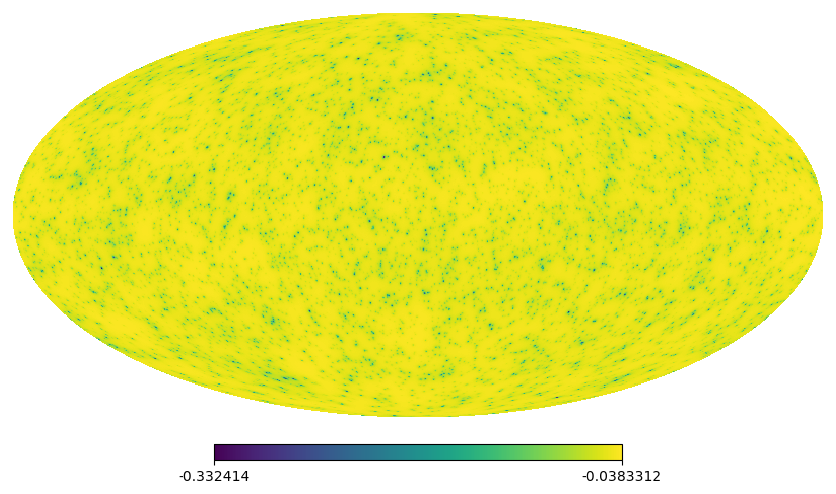

In [72]:
hp.mollview( SZMap, title="" )
SZ = hp.write_map("sim_sz_map" , SZMap , overwrite=True)

In [107]:

sum_map = 1* SZMap  + 0*map_test

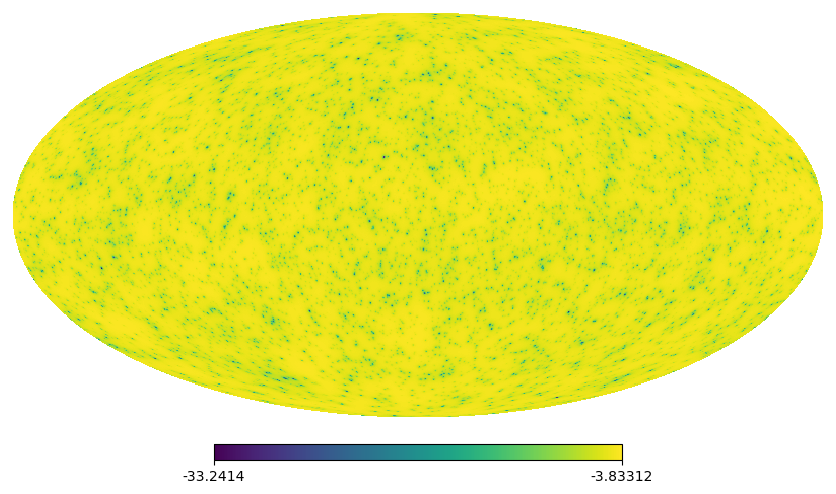

In [94]:
hp.mollview(sum_map , title="")

In [95]:
s0_sz = np.mean(sum_map)

In [886]:
I0sqrt_sz = np.mean(sum_map**2)

In [108]:
s1_sz , i1_sz = ST.compS1(sum_map , morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7
8
9


In [109]:
s2_sz , i2_sz = ST.compS2(i1_sz, morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 0, 'scale(arcmin)')

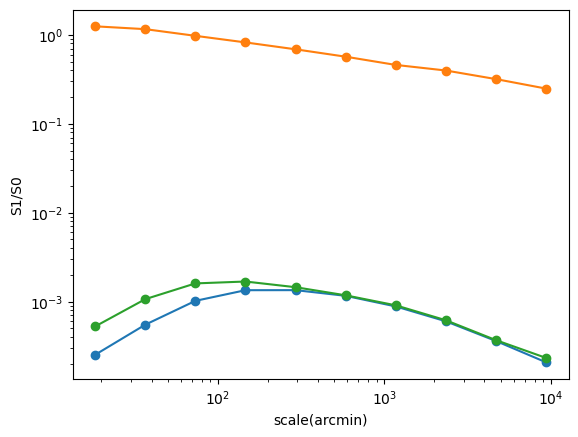

In [113]:
plt.loglog(scale, s1_sz, 'o-', lw=1.5)
plt.loglog(scale, s1, 'o-', lw=1.5)
plt.loglog(scale, s1_gaus, 'o-', lw=1.5)
plt.ylabel("S1/S0")
plt.xlabel("scale(arcmin)")

In [890]:
s2_sum_sz = 0 
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax):
        s2_sum_sz += s2_sz[j1,j2]**2

In [891]:
(I0sqrt_sz-(s0_sz**2))/I0sqrt_sz

0.006129258529292252

In [892]:
np.sum(s1_sz**2)/(I0sqrt_sz-s0_sz**2)

0.0811668780329015

In [893]:
(I0sqrt_sz-(s0_sz**2+np.sum(s1_sz**2)+s2_sum_sz))/I0sqrt_sz

0.005626917076803219

In [894]:
s2_sum_sz/(I0sqrt_sz-s0_sz**2)

0.0007910700758757866

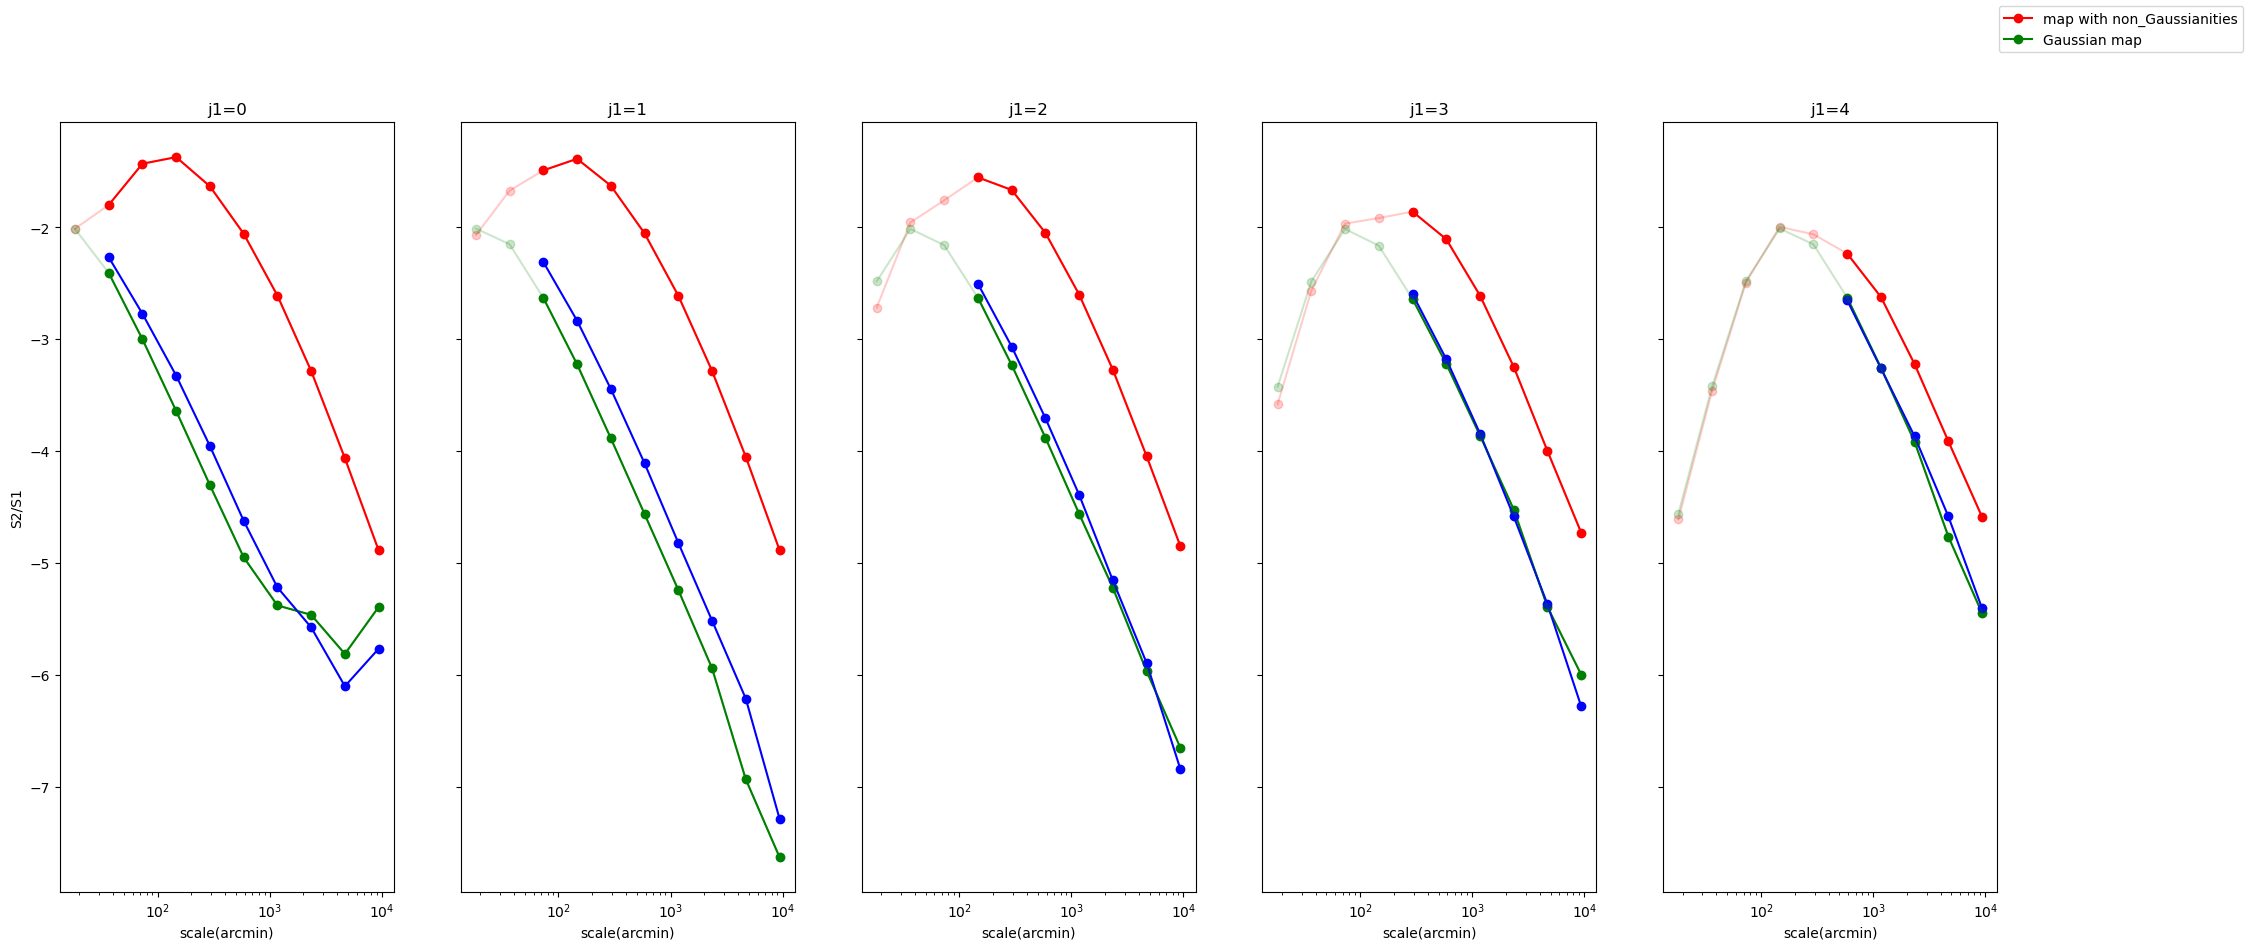

In [115]:
fig, ax = plt.subplots(1, 5,sharey=True,squeeze=True,figsize=(25,10))
for j in range (5):
    ax[j].plot (scale[j+1:],np.log(s2_sz[j,j+1:]/s1_sz[j]),'o-', color = "red")
    ax[j].plot (scale[j+1:],np.log(s2[j,j+1:]/s1[j]),'o-', color = "green")
    ax[j].plot (scale[j+1:],np.log(s2_gaus[j,j+1:]/s1_gaus[j]),'o-', color = "blue")
    ax[j].plot (scale,np.log(s2_sz[j,:]/s1_sz[j]),'o-', alpha = 0.2 , color = "red")
    ax[j].plot (scale,np.log(s2[j,:]/s1[j]),'o-' , alpha = 0.2 , color = "green")
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    #ax[j].legend()
    ax[j].set_xlabel("scale(arcmin)")
    #ax[j].set_ylim([-6.5,-1.7])
ax[0].set_ylabel("S2/S1")
fig.legend (["map with non_Gaussianities" ,"Gaussian map"])

In [101]:
cl_sz = hp.anafast(SZMap)

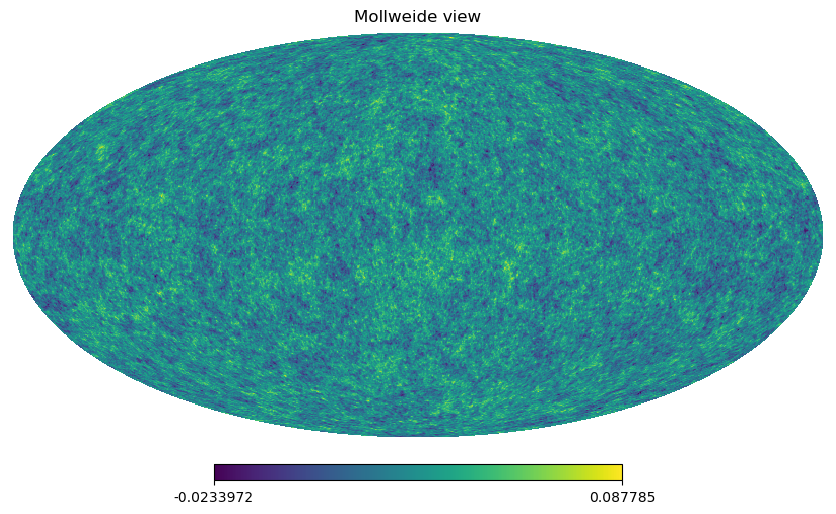

In [103]:
map_gaus = hp.synfast(cl_sz,nside)
hp.mollview(map_gaus)

In [104]:
s1_gaus , i1_gaus = ST.compS1(map_gaus , morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7
8
9


In [106]:
s2_gaus , i2_gaus = ST.compS2(i1_gaus , morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6
7
8
9


In [30]:
nside

1024

In [38]:
imgsize_arcmin = 10 *60
pix_num = int(10*60/res_arcmin)
pix_size = int(np.ceil(imgsize_arcmin / res_arcmin))

In [32]:
from pixell import enmap, utils
box = np.array([[-imgsize_arcmin//2, imgsize_arcmin//2], [imgsize_arcmin//2, -imgsize_arcmin//2]]) * utils.arcmin
box
#shape256, wcs256 = enmap.geometry(pos=box, res=res_arcmin*utils.arcmin, proj='car')
#imap256  = enmap.zeros((3,) + shape256,  wcs=wcs256)
#flat_field = reproject.enmap_from_healpix(map_test,  shape=(pix_num,pix_num),  wcs=imap256.wcs)

array([[-0.08726646,  0.08726646],
       [ 0.08726646, -0.08726646]])

In [36]:
shape256, wcs256 = enmap.geometry(pos=box, res=res_arcmin*utils.arcmin, proj='car')
wcs256

car:{cdelt:[-0.05726,0.05726],crval:[0,0],crpix:[88,88]}

In [34]:
imap256  = enmap.zeros((3,) + shape256,  wcs=wcs256)

In [ ]:
flat_field = reproject.enmap_from_healpix(map_test,  shape=(pix_size, pix_size),  wcs=imap256.wcs)

In [148]:
# Earth image extracted from basemap:
# https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/data/shadedrelief.jpg
img = plt.imread ("/Users/arefe/Downloads/cat.jpg")[:,:,0]
img = img.astype('float')
from PIL import Image
from matplotlib.image import pil_to_array
grayscale_pil_image = Image.open("/Users/arefe/Downloads/shadedrelief.jpg").convert("L")
image_array = pil_to_array(grayscale_pil_image)

In [157]:
theta = np.linspace(0, np.pi, num=image_array.shape[0])[:, None]
phi = np.linspace(-np.pi, np.pi, num=image_array.shape[1])

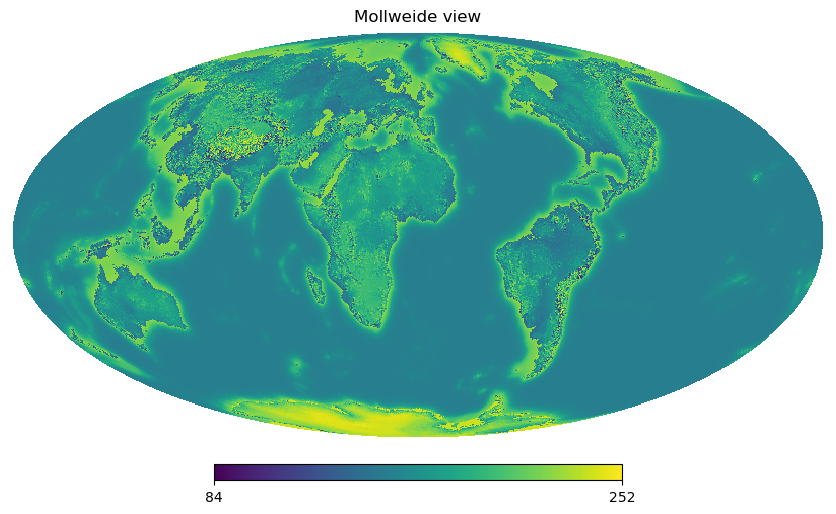

In [158]:
pix = hp.ang2pix(nside, theta, phi)
map_earth = np.zeros(hp.nside2npix(nside), dtype=np.double)
map_earth[pix] = image_array
hp.mollview(map_earth)
#hp.title("Mollweide view of the Earth")

In [159]:
s1_earth , i1_earth = compS1(map_earth , morlet_l_arr, jmax, nside)

0
1
2
3
4
5
6


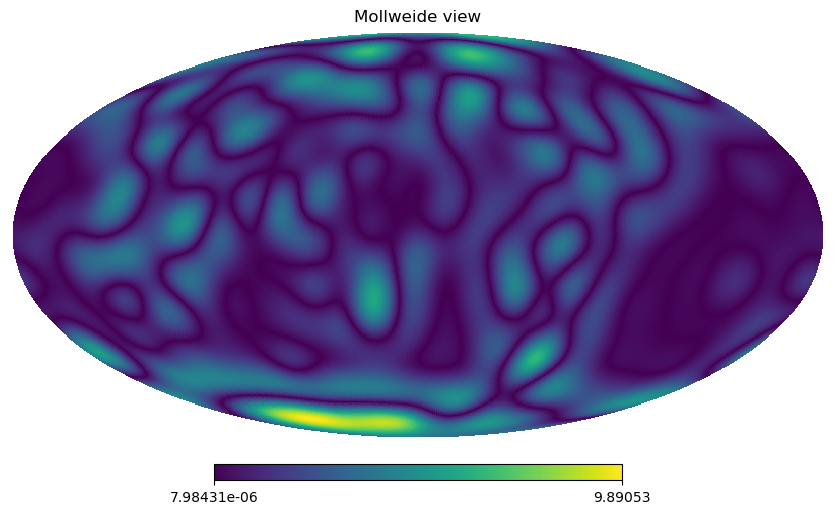

In [164]:
hp.mollview(i1_earth[5])